# Recurrent Neural Networks

In this tutorial we will use autoregressive approaches for virtual sensors to calculate the system response of an ESP System with external force from a shaker. The tutorial provides an introduction to virtual sensors for dynamic systems. This tutorial focusses on applying recurrent approaches, other models are discussed in the other two tutorials on linear models `linear_models.ipynb` and Autoregressive Neural Networks `ARNN.ipynb`. Recurrent Neural Networks are a modern approach to predict forced time series in multiple applications

## Loading Data
In a first step we load the already measured data and convert them into `pandas.DataFrames`. Our example Data consists of three individually Measured datasets. To load the data properly we need information about the specific sensors. In our case the sensor names are straight forward: 
 * input_1-9 as our 9 input signals
 * output_1-3 as out 3 output signals
 
Furthermore, (if not given as `time` in the mat file) we need the corrosponsing sampling rate `fs` of the data.In our case:
 * fs=50000

Fixing the sampling rate will raise an Attention Message. We save the individual Measurments in a list of `pandas.DataFrames`

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
data_path = os.path.join(os.path.abspath(""), 'data')

input_sensors = [f'input_{i}' for i in range(1, 10)]
output_sensors = [f'output_{i}' for i in range(1, 4)]

file_names = [f for f in os.listdir(data_path) if
                    os.path.isfile(os.path.join(data_path, f))]
df_list = [pd.read_parquet(os.path.join(data_path, n)) for n in file_names]
fs = 1/np.mean(df_list[0].index.diff().dropna())

## Plot the Data
Before we start with the actual preprocessing we want to plot the given data to get a feeling for the properties. These are high-frequency acceleration data recorded on a shaker. For convinience we just plot the first entry of our list of DataFrames
<img src="./img/Mehrachspruefstand.jpg" alt="" width="600"/>.

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>], dtype=object)

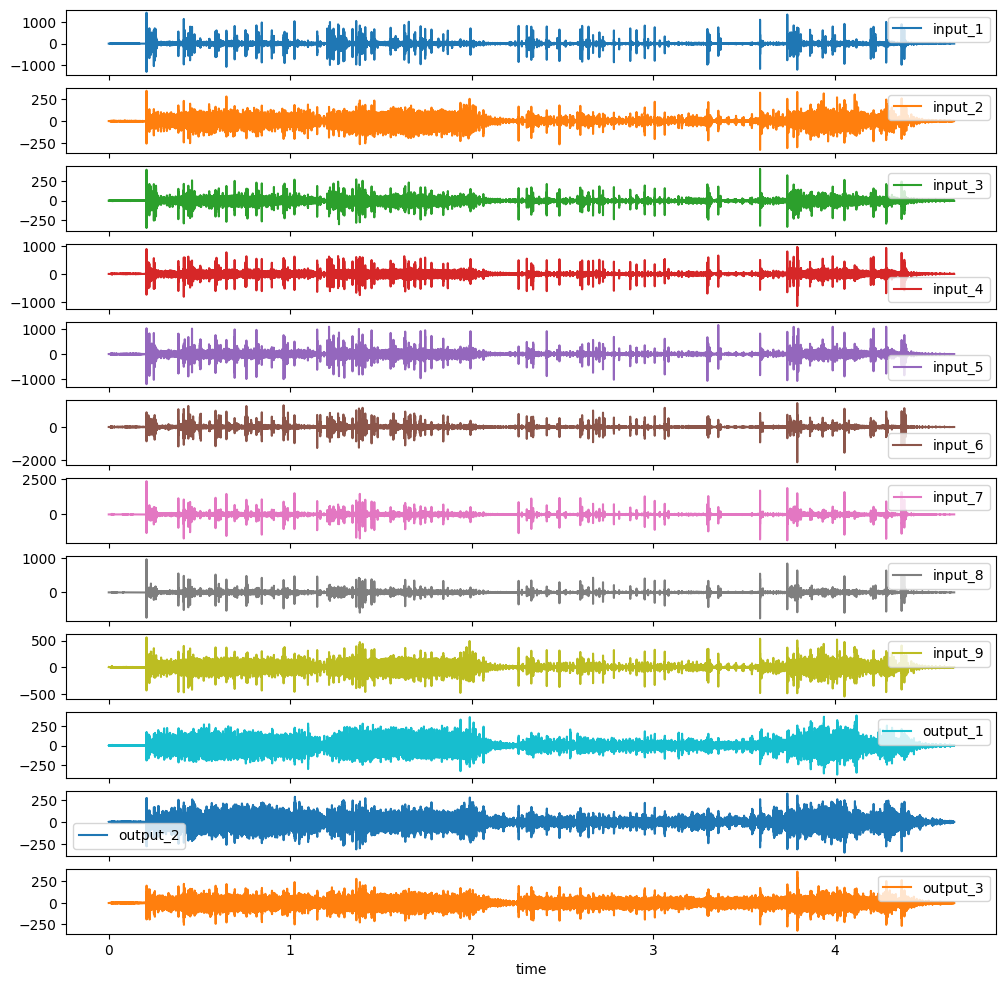

In [3]:
df_list[0].plot(subplots=True, sharex=True, figsize=(12,12))

## Data Preprocessing

When looking at the data, the high range in which the accelerations move is striking. For many machine learning models, preprocessing is therefore necessary. Our toolbox uses the class `Meas_handling` for the entire preprocessing. `Meas_handling` is used to transform the data into a normally distributed range. Furthermore, the entire frequency range is not relevant for our analysis. Therefore, we sample the data from 50000 Hz to 10000 Hz and then filter between 90 and 4000 Hz.

Furtehrmore we split the data in training and evaluation data. We use the first two Measurments as training and the last one as evaluation

In [4]:
from softsensor.meas_handling import Meas_handling
from sklearn.preprocessing import StandardScaler

data_handle = Meas_handling(df_list[:2], file_names[:2], input_sensors, output_sensors, fs,
                            df_list[2:], file_names[2:])

data_handle.Resample(fs=10000)
freq_lim = (90, 4000)
data_handle.Filter(freq_lim)
data_handle.Scale(StandardScaler())

## Define Model
We define two different Models in our example. 
First we define a Gated Recurrent Unit (GRU) Network to approximate the functional dependency between input and output as linear combinations. Compared to the autoregressive neural networks described in `ARNN.ipynb`, GRU models do not feed back the output directly but utilise a hidden state $h(t)$ which mimics the system state. In most applications it seems advantageous to utilise subsequent feed forward layers after the GRU cells.

$y_i(t+1) = f(\mathbf{x}_i(t, ..., t-w_x), h(t))$

This RNN model take the following inputs:
 * number of input channels (`input_channels`)
 * number of output channels (`pred_size`)
 * window size (`window_size`)
 * number of parallel GRU cells (`blocks`)
 * depth of the GRU (`num_layers`)
 * blocktype (`GRU`)
 * neurons in the subsequent feed forward network (`hidden_size`)


In [5]:
from softsensor.recurrent_models import RNN_DNN
from torchinfo import summary

gru = RNN_DNN(input_channels=9, pred_size=3, window_size=50, blocks=32, num_layers=1, hidden_size=[32, 16],
               blocktype='GRU', activation='leaky_relu')
print(gru)
summary(gru)

RNN_DNN(
  (RecBlock): _GRU(
    (gru): GRU(450, 32, batch_first=True)
  )
  (DNN): Feed_ForwardNN(
    (DNN): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=32, out_features=16, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=16, out_features=3, bias=True)
    )
  )
)


Layer (type:depth-idx)                   Param #
RNN_DNN                                  --
├─_GRU: 1-1                              --
│    └─GRU: 2-1                          46,464
├─Feed_ForwardNN: 1-2                    --
│    └─Sequential: 2-2                   --
│    │    └─Linear: 3-1                  1,056
│    │    └─LeakyReLU: 3-2               --
│    │    └─Linear: 3-3                  528
│    │    └─LeakyReLU: 3-4               --
│    │    └─Linear: 3-5                  51
Total params: 48,099
Trainable params: 48,099
Non-trainable params: 0

After we have defined the model, the next step is to adapt the model to the data. The training and validation data can be extracted from the predefined `data_handle` class and then trained using the `train_model` function. For GRU the Input data needs to be defined differently. The time series have to be gone through individually in the correct order compared to the use of ARNN (`tutorials/02_ARNN`). We therefore need a list of loaders, each entry containing one of the training time series. The `Meas_handling` class provides a functionality for this. The method needs as input:

* `window_size`: defines the length of the time window, needs to be the same as for the model
* `keyword`: either `training` or `short`, training uses the whole training dataset, while short uses only a small subset
* `batch_size`: batch size of the individual loaders in the list
* `Add_zeros`: Adds zeros at the beginning of the time series to mimic start from idle state

In [6]:
list_train_loader = data_handle.give_list(gru.window_size, keyword='training',
                                          batch_size=128, Add_zeros=True)

Furthermore, some training parameters are needed, which have to be passed to the class `train_model`:

* `model`: ARNN to be trained
*  `train_loader`: training data (list of data loaders)
* `max_epochs`: maximum number of epochs for training
* `optimizer`: optimizer used  for optimization, check [Link](https://pytorch.org/docs/stable/optim.html) for different possibel optimizers
* `device`: device for training
* `criterion`: loss function to train against check [Link](https://pytorch.org/docs/stable/nn.html#loss-functions) for possibel criterions
* `val_loader`: validation data (list of data loaders)
* `print_results`: if True, results are printed


In [7]:
from softsensor.train_model import train_model
import torch.optim as optim
import torch.nn as nn

opt = optim.Adam(gru.parameters(), lr=1e-4, weight_decay=1e-3)
crit = nn.MSELoss()

results = train_model(gru, list_train_loader, max_epochs=30, optimizer=opt, device='cpu', criterion=crit,
                      val_loader=None, print_results=True)

$\textbf{Congratulation!!!}$ you have successfully fitted a Gated Recurrent Unit Network to the training data

The linear transfer function is used as a benchmark in the following. A detailed explanation can be found in `tutorials\linear_models

In [8]:
from softsensor.arx import ARX
arx = ARX(order=[50, 50])
arx.fit(data_handle.train_df, input_sensors, output_sensors)

## Model Evaluation
To Evaluate our model on testing data we use the predefined functions `comp_pred`, which computes the prediction for a defined track in the data_handle class. As track we choose our testing track, which can be accessed using the internal variable `test_names`. Furthermore we compute

In [9]:
from softsensor.eval_tools import comp_pred, comp_error
track = data_handle.test_names[0]
models = [gru, arx]
pred_df = comp_pred(models, data_handle, track, names=['GRU', 'ARX'])

<Axes: >

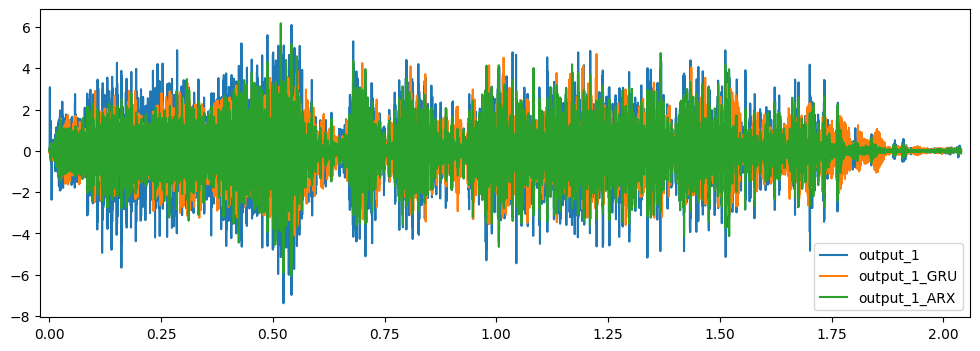

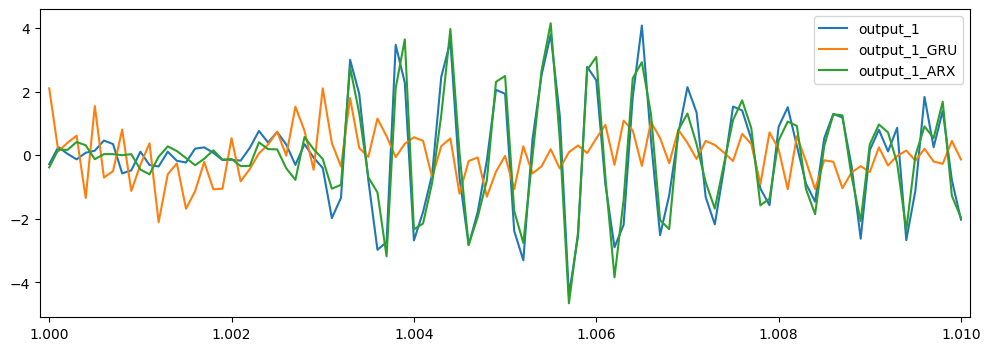

In [10]:
pred_df.filter(regex='output_1').plot(figsize=(12,4))
pred_df.filter(regex='output_1')[1:1.01].plot(figsize=(12,4))

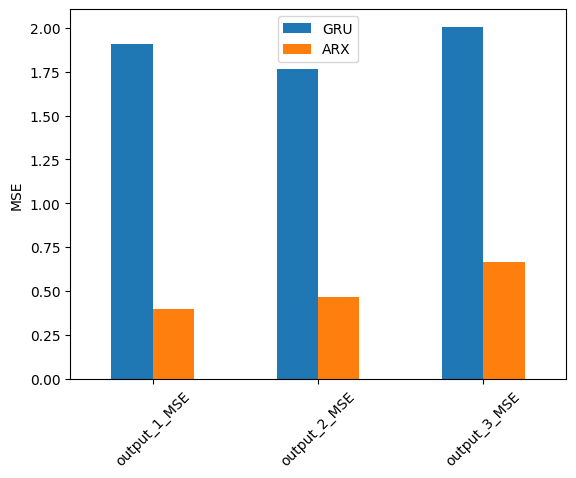

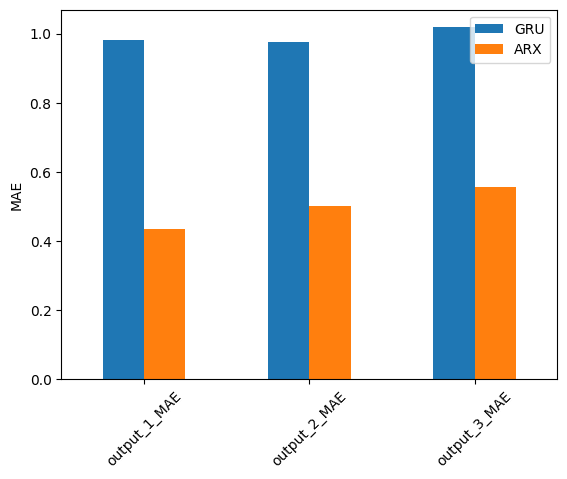

In [11]:
error = comp_error(pred_df, output_sensors, fs, names=['GRU', 'ARX'], metrics=['MSE', 'MAE'], freq_range=freq_lim)
for n in ['MSE', 'MAE']:
    error.filter(regex=n, axis=0).plot.bar(ylabel=f'{n}', rot=45)